In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
#Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to calculate MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def generate_temperature_metrics(
    path: str,
    months: [int],
    days: [int],
    month_idx: int,
    mean: int,
    std: int,
    save=False,
    input_days=7
):
    """
    Month: [0,11]
    Day: [0,6]
    day_of_week: {4: 0, 5: 1, 6: 2, 0: 3, 1: 4, 2: 5, 3: 6}
    """
    
    #Function to calculate RMSE
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    # Function to calculate MAPE
    def mape(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    observed = []
    predicted = []

    eia_data = pd.read_csv(
        "../data/final_tables/erco_2023_andcomposite/erco_2023_andcomposite.csv"
    )
    data_2023 = eia_data[(eia_data["2023"] == 1) & (eia_data["year"] == 2023)]

    actual_months = [m + 1 for m in months]
    df = data_2023[data_2023["month"].isin(actual_months)][
        ["day_of_week", "hour", "Demand Forecast (MWh)"]
    ]
    df.rename(
        columns={
           "Demand Forecast (MWh)": "eia_forecast" 
        },
        inplace=True
    
    )
    
    with open(path, "r") as file:
        data = json.load(file)

        for month in months:
            # Step 1: find start index
            start_idx = 0 if month != 11 else input_days
            while True:
                source = data["source_readings"][start_idx]
                m = source[0][month_idx]
                if m == month:
                    break
                else:
                    start_idx += 1

            idx = start_idx - input_days
            while True:
                source = data["source_readings"][
                    min(idx + input_days, len(data["source_readings"]) - 1)
                ]

                m = source[0][month_idx]
                if m != month or idx > len(data["source_readings"]) - 1:
                    break
                expected_ex = data["expected"][idx]
                predicted_ex = data["predicted"][idx]

                observed += expected_ex
                predicted += predicted_ex

                idx += 1
        predicted = np.array(predicted) * std + mean
        observed = np.array(observed) * std + mean
        
        df["predicted"] = predicted
        df["observed"] = observed
        
        
        df_filtered = df[df['day_of_week'].isin(days)]
        
        print(f"Model RMSE: {rmse(np.array(df_filtered['predicted']),np.array(df_filtered['observed']))}")
        print(f"EIA RMSE: {rmse(np.array(df_filtered['eia_forecast']), np.array(df_filtered['observed']))}")
        print(f"Model MAE: {mean_absolute_error(np.array(df_filtered['predicted']),np.array(df_filtered['observed']))}")
        print(f"EIA MAE: {mean_absolute_error(np.array(df_filtered['observed']),np.array(df_filtered['eia_forecast']))}")
        print(f"Model MAPE: {mape(np.array(df_filtered['observed']),np.array(df_filtered['predicted']))}")
        print(f"EIA MAPE: {mape(np.array(df_filtered['observed']), np.array(df_filtered['eia_forecast']))}")
        
        
#         plt.figure()
#         plt.plot(np.array(df_filtered['predicted']))
#         plt.plot(np.array(df_filtered['observed']))
#         plt.show()
              
#         plt.figure()
#         plt.plot(np.array(df_filtered['eia_forecast']))
#         plt.plot(np.array(df_filtered['observed']))
#         plt.show()
        
        
        # Initialize a DataFrame to store the results
        results = pd.DataFrame(columns=['Hour', 'Metric', 'EIA_Forecast', 'Predicted'])

        # Loop over each hour
        for hour in df_filtered['hour'].unique():
            # Filter the DataFrame by the current hour
            df_hour = df_filtered[df_filtered['hour'] == hour]

            # Calculate metrics
            rmse_eia = rmse(df_hour['observed'], df_hour['eia_forecast'])
            mae_eia = mean_absolute_error(df_hour['observed'], df_hour['eia_forecast'])
            mape_eia = mape(df_hour['observed'], df_hour['eia_forecast'])

            rmse_pred = rmse(df_hour['observed'], df_hour['predicted'])
            mae_pred = mean_absolute_error(df_hour['observed'], df_hour['predicted'])
            mape_pred = mape(df_hour['observed'], df_hour['predicted'])

            # Append results to the results DataFrame
            results = results.append({'Hour': hour, 'Metric': 'RMSE', 'EIA_Forecast': rmse_eia, 'Predicted': rmse_pred}, ignore_index=True)
            results = results.append({'Hour': hour, 'Metric': 'MAE', 'EIA_Forecast': mae_eia, 'Predicted': mae_pred}, ignore_index=True)
            results = results.append({'Hour': hour, 'Metric': 'MAPE', 'EIA_Forecast': mape_eia, 'Predicted': mape_pred}, ignore_index=True)

        # Pivot the results for easier comparison
        pivot_results = results.pivot(index='Hour', columns='Metric', values=['EIA_Forecast', 'Predicted'])
        
        df_metrics = pivot_results
        # Plot settings
        plt.figure(figsize=(18, 6))

        # List of metrics to plot
        metrics = ['RMSE', 'MAE', 'MAPE']

        label = path.split('/')[-1].split('_')[0]
              
        # Plot each metric
        for i, metric in enumerate(metrics, 1):
            plt.subplot(1, 3, i)  # 1 row, 3 columns, ith subplot
            plt.plot(df_metrics.index, df_metrics[('EIA_Forecast', metric)], label='ERCOT', marker='o')
            plt.plot(df_metrics.index, df_metrics[('Predicted', metric)], label=label, marker='x')
            plt.title(f'{metric} by Hour')
            plt.xlabel('Hour')
            plt.ylabel(metric)
            plt.legend()
            plt.ylim(bottom=0)
            plt.grid(True)
        plt.tight_layout(rect=[0, 0.03, 1, 0.9])  # Adjust the top margin to increase space for the suptitle

        
        # Add a master title
#         plt.suptitle(f'Forecast Accuracy for Months {[months_map[m] for m in actual_months]}\n and Days {[days_map[d] for d in days]}', fontsize=16, fontweight='bold')
        
        if save:
            title=path.split('/')[-1].split('_')[0]+'_' + ''.join(str(m) for m in actual_months) + '_' + ''.join(str(d) for d in days)
            plt.savefig(f"/Users/aidanwiteck/Desktop/Princeton/Year 4/Thesis/Homeworks/SpringInterimReport/{title}.pdf", 
                            format="pdf", 
                            bbox_inches="tight")
        plt.show()

        return pivot_results

In [3]:
eia_data = pd.read_csv(
        "../data/final_tables/erco_2023_andcomposite/erco_2023_andcomposite.csv"
    )

In [7]:
eia_data[eia_data['Region']=='erco'].head()

,timestamp,Demand (MWh),Demand Forecast (MWh),Net Generation (MWh),Region,Normalized Demand,Normalized Forecast,temperature,humidity,cloudcover,windspeed,year,month,day_of_week,day,hour,region_id,2023
61369,2016-01-01 00:00:00,34680.0,36278.0,34655.0,erco,-0.870715,-0.711566,9.1,66,95,20.3,2016,1,4,1,0,1.0,0
61370,2016-01-01 01:00:00,33846.0,34382.0,33886.0,erco,-0.953776,-0.900394,8.3,64,90,21.9,2016,1,4,1,1,1.0,0
61371,2016-01-01 02:00:00,33427.0,34078.0,33469.0,erco,-0.995505,-0.930670,8.1,63,94,21.6,2016,1,4,1,2,1.0,0
61372,2016-01-01 03:00:00,33086.0,33807.0,33129.0,erco,-1.029466,-0.957660,7.9,62,93,22.4,2016,1,4,1,3,1.0,0
61373,2016-01-01 04:00:00,33048.0,33524.0,33090.0,erco,-1.033251,-0.985844,7.7,60,91,23.9,2016,1,4,1,4,1.0,0


In [8]:
eia_data = eia_data[eia_data['Region']=='erco']

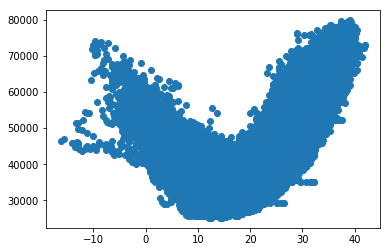

In [9]:
plt.scatter(eia_data["temperature"], eia_data["Demand (MWh)"])

In [15]:
train_data = eia_data = pd.read_csv(
    "../data/final_tables/erco/erco_train.csv"
)

In [16]:
train_data.head()

,timestamp,Demand (MWh),Demand Forecast (MWh),Net Generation (MWh),Region,Normalized Demand,Normalized Forecast,temperature_1,humidity_1,cloudcover_1,...,humidity_6,cloudcover_6,windspeed_6,precipitation_6,year,month,day_of_week,day,hour,is_holiday
0,2016-01-01 00:00:00,34680.0,36278.0,34655.0,erco,-0.913845,-0.762266,-1.564565,0.480726,1.555971,...,2.121060,2.628561,0.477293,-0.108163,1,0,4,0,0,1
1,2016-01-01 01:00:00,33846.0,34382.0,33886.0,erco,-0.992954,-0.942111,-1.618373,0.653263,1.555971,...,2.077309,2.628561,0.435506,-0.108163,1,0,4,0,1,1
2,2016-01-01 02:00:00,33427.0,34078.0,33469.0,erco,-1.032698,-0.970947,-1.658730,0.365701,1.555971,...,1.989806,2.628561,0.338005,0.147122,1,0,4,0,2,1
3,2016-01-01 03:00:00,33086.0,33807.0,33129.0,erco,-1.065043,-0.996653,-1.658730,0.193164,1.555971,...,1.989806,2.628561,0.491221,-0.108163,1,0,4,0,3,1
4,2016-01-01 04:00:00,33048.0,33524.0,33090.0,erco,-1.068648,-1.023497,-1.672182,0.078140,1.555971,...,1.946055,2.628561,0.588722,-0.108163,1,0,4,0,4,1


In [12]:

# One-hot encode the 'month', 'day_of_week', 'hour', and 'Region' columns
categorical_columns = ['month', 'day_of_week', 'hour', 'Region']
train_data = pd.get_dummies(train_data, columns=categorical_columns)

In [14]:
train_data.columns

Index(['timestamp', 'Demand (MWh)', 'Demand Forecast (MWh)',
       'Net Generation (MWh)', 'Normalized Demand', 'Normalized Forecast',
       'temperature_1', 'humidity_1', 'cloudcover_1', 'windspeed_1',
       'precipitation_1', 'temperature_2', 'humidity_2', 'cloudcover_2',
       'windspeed_2', 'precipitation_2', 'temperature_3', 'humidity_3',
       'cloudcover_3', 'windspeed_3', 'precipitation_3', 'temperature_4',
       'humidity_4', 'cloudcover_4', 'windspeed_4', 'precipitation_4',
       'temperature_5', 'humidity_5', 'cloudcover_5', 'windspeed_5',
       'precipitation_5', 'temperature_6', 'humidity_6', 'cloudcover_6',
       'windspeed_6', 'precipitation_6', 'year', 'day', 'is_holiday',
       'month_0', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'hour_0', 'h

In [17]:
# Assuming 'df' is your DataFrame before one-hot encoding
original_columns = set(train_data.columns)

# Define the categorical columns you want to one-hot encode
categorical_columns = ["year", "month", "day", "day_of_week", "hour", "Region"]

# Perform one-hot encoding
train_data = pd.get_dummies(train_data, columns=categorical_columns)

# Capture the list of columns after one-hot encoding
all_columns_after_encoding = set(train_data.columns)

# Identify the new one-hot encoded columns by finding the difference
new_one_hot_encoded_columns = list(all_columns_after_encoding - original_columns)

# Now, new_one_hot_encoded_columns contains only the columns added by pd.get_dummies
print(new_one_hot_encoded_columns)

['month_1', 'day_19', 'hour_14', 'day_12', 'hour_22', 'year_7', 'day_26', 'hour_20', 'day_6', 'day_17', 'day_of_week_5', 'day_18', 'month_10', 'hour_2', 'day_16', 'day_1', 'day_15', 'year_4', 'day_0', 'day_of_week_4', 'hour_16', 'year_2', 'hour_18', 'day_8', 'day_21', 'month_9', 'Region_erco', 'month_7', 'hour_1', 'day_of_week_1', 'hour_10', 'month_2', 'hour_21', 'day_14', 'day_7', 'hour_11', 'hour_5', 'year_3', 'year_1', 'hour_12', 'day_10', 'day_5', 'day_9', 'hour_15', 'hour_23', 'hour_4', 'hour_17', 'hour_3', 'hour_7', 'year_6', 'day_of_week_2', 'hour_6', 'year_5', 'month_11', 'hour_9', 'day_27', 'month_6', 'day_23', 'day_13', 'day_24', 'month_5', 'day_30', 'day_of_week_3', 'day_4', 'hour_13', 'day_25', 'month_0', 'day_29', 'day_11', 'day_of_week_6', 'day_28', 'day_of_week_0', 'hour_19', 'month_3', 'day_22', 'day_2', 'hour_0', 'hour_8', 'day_20', 'month_8', 'month_4', 'day_3']


In [19]:
# Check data types of the columns
input_vars = ["month_1", "temperature_1"]
print(train_data[input_vars].dtypes)

month_1            uint8
temperature_1    float64
dtype: object
